In [282]:
import csv
import pandas as pd
import datetime as datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import dateutil.parser
import re
import pytz
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [283]:
# Load the data

# Load the actual values from the automatic weather observation system (SMN) in Zollikofen. 
df_smn = pd.read_csv('data/smn.csv')

# Load the values from the 5 day weather forecast.

# Meteo Schweiz
df_meteoschweiz = pd.read_csv('data/meteoschweiz.csv')
df_meteoschweiz_symbs = pd.read_csv('data/meteoschweiz_symb.csv')

# SRF Meteo
df_srf = pd.read_csv('data/srf.csv')

# Meteotest
df_meteotest = pd.read_csv('data/meteotest.csv')

# Meteonews
df_meteonews = pd.read_csv('data/meteonews.csv')

In [284]:
df_smn.head()

,code,dateTime,gustPeak,humidity,windSpeed,windDirection,qnhPressure,temperature,precipitation,sunshine,qfePressure,qffPressure
0,BER,2016-08-04T04:50:00.000Z,4.0,90.0,2.5,223.0,1016.6,13.6,0.0,0.0,951.6,1015.9
1,BER,2016-08-04T05:50:00.000Z,5.0,88.0,3.6,232.0,1016.5,15.2,0.0,10.0,951.5,1015.4
2,BER,2016-08-04T06:50:00.000Z,5.8,72.0,4.0,203.0,1016.6,18.7,0.0,10.0,951.6,1014.7
3,BER,2016-08-04T07:50:00.000Z,8.6,60.0,5.0,172.0,1016.3,21.0,0.0,10.0,951.3,1013.8
4,BER,2016-08-04T08:50:00.000Z,7.6,55.0,3.2,258.0,1016.2,22.3,0.0,10.0,951.2,1013.4


In [285]:
# Preprocess the data. 

# Convert the time column to index (time series) 
def parse_date(str_date):
    temp = dateutil.parser.parse(str_date)
    try:
        return pytz.utc.localize(temp)
    except ValueError: 
        return temp

def drop_degree(str_deg):
    temp = re.search(r'\d+',str_deg)
    return float(temp.group(0))

# SMN
df_smn['time'] = df_smn['dateTime'].apply(parse_date)
df_smn.index = df_smn['time']
df_smn = df_smn.drop('time',axis=1)
df_smn = df_smn.drop('dateTime',axis=1)

# Meteonews
df_meteonews['time'] = df_meteonews['time'].apply(parse_date)
df_meteonews.index = df_meteonews['time']
df_meteonews = df_meteonews.drop('time',axis=1)

# SRF
df_srf['time'] = df_srf['time'].apply(parse_date)
df_srf.index = df_srf['time']
df_srf = df_srf.drop('time',axis=1)
df_srf['temp'] = df_srf['temp'].apply(drop_degree)

# Meteotest
df_meteotest['date'] = df_meteotest['date'].apply(parse_date)
df_meteotest.index = df_meteotest['date']
df_meteotest = df_meteotest.drop('date',axis=1)

# Meteo Schweiz
df_meteoschweiz.columns = ['time','temp','rain']
df_meteoschweiz['time'] = df_meteoschweiz['time'].apply(parse_date)
df_meteoschweiz.index = df_meteoschweiz['time']
df_meteoschweiz = df_meteoschweiz.drop('time',axis=1)

df_meteoschweiz_symbs.columns = ['time','symb']
df_meteoschweiz_symbs['time'] = df_meteoschweiz_symbs['time'].apply(parse_date)
df_meteoschweiz_symbs.index = df_meteoschweiz_symbs['time']
df_meteoschweiz_symbs = df_meteoschweiz_symbs.drop('time',axis=1)

In [286]:
# Merge the datasets

# SMN and Meteonews
df = pd.merge(df_smn, df_meteonews, right_index=True, left_index=True, how='outer')
df = df[['temperature','temp']]
df.columns = ['temp_smn','temp_meteonews']

# Adding Meteotest
df = pd.merge(df, df_meteotest, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest']

# Adding MeteoSchweiz
df = pd.merge(df, df_meteoschweiz, right_index=True, left_index=True, how='outer') # Why??
df = df[['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp']]
df.columns = ['temp_smn', 'temp_meteonews', 'temp_meteotest', 'temp_meteoschweiz']

# Adding SRF
df = pd.merge(df, df_srf, right_index=True, left_index=True, how='outer')
df = df[['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp']]
df.columns = ['temp_smn','temp_meteonews','temp_meteotest', 'temp_meteoschweiz', 'temp_srf']

In [287]:
df.count()

temp_smn             785
temp_meteonews        62
temp_meteotest       144
temp_meteoschweiz    140
temp_srf              47
dtype: int64

## Graphs

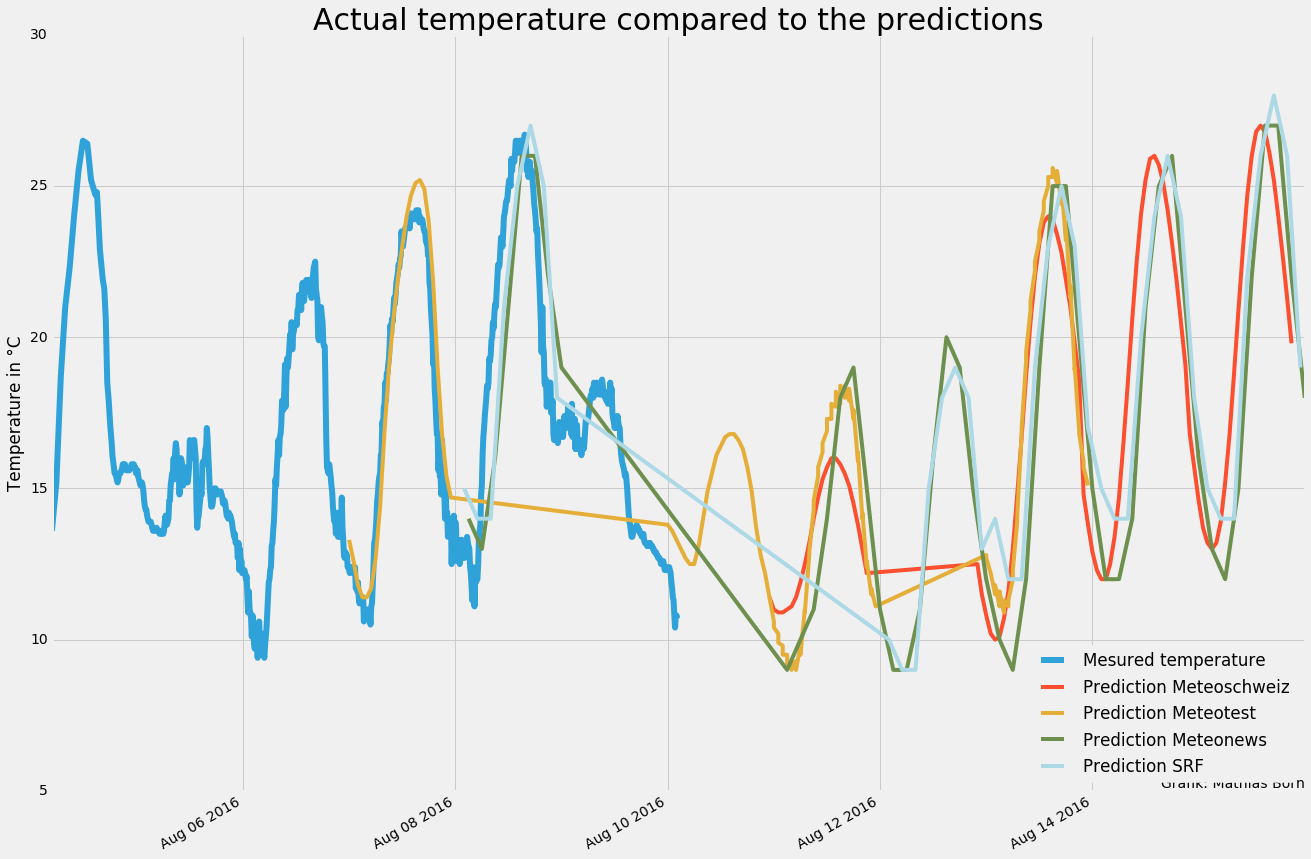

In [293]:
# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(20,15))

# Pass the ax to the .plot function
df['temp_smn'].dropna().plot(kind='line', label='Mesured temperature', legend=True, linewidth=6, ax=ax)
df['temp_meteoschweiz'].dropna().plot(kind='line', label='Prediction Meteoschweiz', legend=True, ax=ax)
df['temp_meteotest'].dropna().plot(kind='line', label='Prediction Meteotest', legend=True, ax=ax)
df['temp_meteonews'].dropna().plot(kind='line', label='Prediction Meteonews', legend=True, ax=ax)
df['temp_srf'].dropna().plot(kind='line', label='Prediction SRF', color='lightblue', legend=True, ax=ax)

ax.set_ylabel("Temperature in °C")
ax.set_title("Actual temperature compared to the predictions", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/temperature.png')

## Calculate offset

In [294]:
# Calculating the offset in degrees.

df['temp_offset_meteonews'] = df['temp_smn'] - df['temp_meteonews']
df['temp_offset_meteotest'] = df['temp_smn'] - df['temp_meteotest']
df['temp_offset_meteoschweiz'] = df['temp_smn'] - df['temp_meteoschweiz']
df['temp_offset_srf'] = df['temp_smn'] - df['temp_srf']

In [295]:
# Calculating the offset in percent.

df['temp_offset_meteonews_percent'] = abs(100 * df['temp_offset_meteonews'] / df['temp_smn'])
df['temp_offset_meteotest_percent'] = abs(100 * df['temp_offset_meteotest'] / df['temp_smn'])
df['temp_offset_meteoschweiz_percent'] = abs(100 * df['temp_offset_meteoschweiz'] / df['temp_smn'])
df['temp_offset_srf'] = abs(100 * df['temp_offset_srf'] / df['temp_smn'])

In [296]:
df[['temp_offset_meteonews_percent','temp_offset_meteotest_percent', 'temp_offset_meteoschweiz_percent', 'temp_offset_srf']].describe()

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,temp_offset_meteonews_percent,temp_offset_meteotest_percent,temp_offset_meteoschweiz_percent,temp_offset_srf
count,7.000000,30.000000,0.0,8.000000
mean,13.021723,5.971517,NaN,15.322017
std,8.048770,5.484513,NaN,9.136872
min,1.886792,0.432900,NaN,4.942966
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,24.170616,23.148148,NaN,28.205128


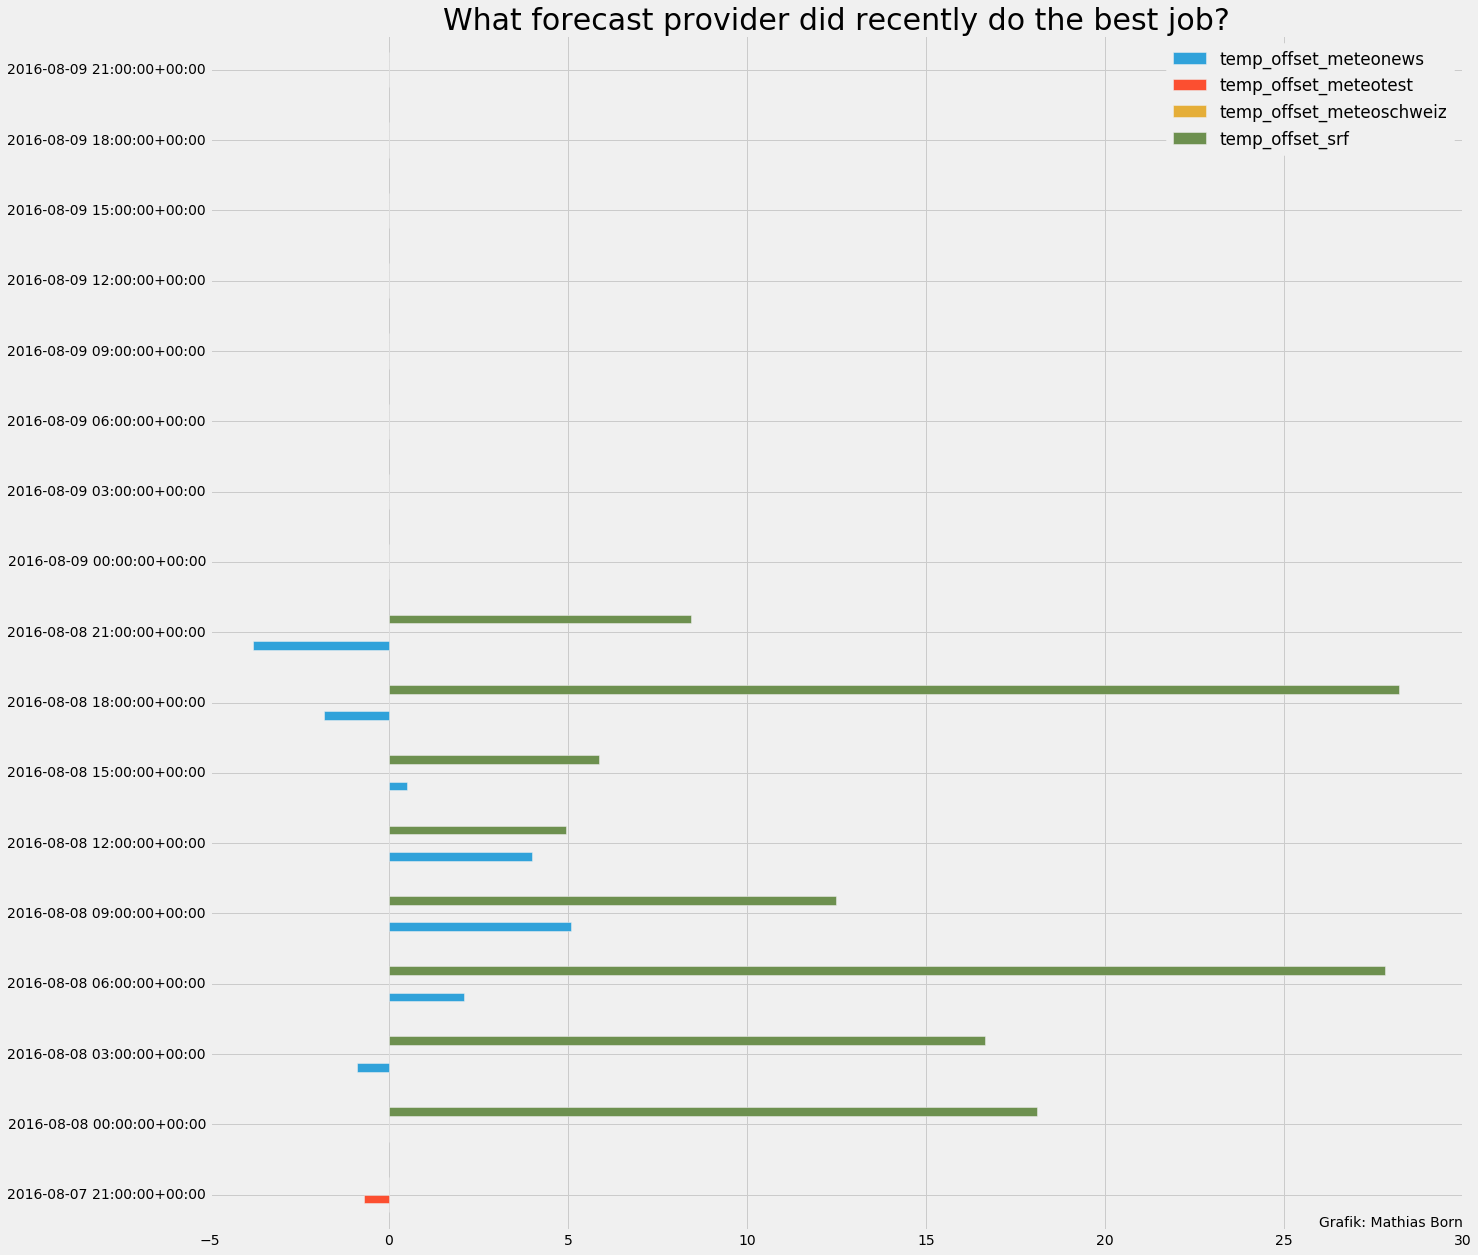

In [297]:
time1 = str(datetime.datetime.now() - timedelta(days=2))
time2 = str(datetime.datetime.now())

# Initialize the plot first, take the ax
fig, ax = plt.subplots(figsize=(20,20))

# Pass the ax to the .plot function
df[time1:time2][['temp_offset_meteonews','temp_offset_meteotest', 'temp_offset_meteoschweiz', 'temp_offset_srf']].resample('3H').mean().plot(ax=ax, label=['Offset Meteonews', 'Offset Meteotest', 'Offset Meteoschweiz', 'Offset SRF'], legend=True, kind='barh')
ax.set_title("What forecast provider did recently do the best job?", fontsize=30)
ax.annotate('Grafik: Mathias Born', xy=(1, 0), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

fig.savefig('output/offset.png')